# The Probabilistic Profile Neural Network
This notebook contains code to replicate the results of ProbPNN realised in a non-sequential machine learning pipeline demonstrated at deRSE-2023. This code is based on the following paper:
>Benedikt Heidrich, Kaleb Phipps, Oliver Neumann, Marian Turowski, Ralf Mikut, and Veit Hagenmeyer. 2023. ProbPNN: Enhancing Deep Probabilistic Forecasting with Statistical Information. arXiv:2302.02597

<br/>

### What is the ProbPNN
Before getting to the code lets briefly look at the ProbPNN. The fundamental assumption behind the ProbPNN is that many time series exhibit calendar driven periodicities which we can use to our advantage to improve forecasting performance. For example, a time series modelling traffic congestion will probably show a strong daily periodicity, with peaks for the rush-hour in the morning and evening as commuters travel to and from work. Furthermore, this traffic congestion time series will show a weekly periodicity when the majority of commuters do not travel to work on the weekend leading to less congestion on Saturday and Sunday. You can observe periodicites in many other time series.

The ProbPNN takes advantage of these calendar periodicites and uses statistical information to improve probabilistic forecasts:
- We calculate a rolling average and rolling variance by statistically grouping the time series using calendar information.
- This grouping works by considering values that are "similar" according to their calendar information when calculating the statistics, for example the statistics calculated for Monday noon are calculated by considering the values at noon on previous working days. Similarly, the statistics for midnight on saturday are calculated by considering midnight values for previous weekends.
- As a result, we implicitly include the calender-driven periodicites in this statistical information.

This statistical information is not the entire story though:
- The ProbPNN also includes a trend component which predicts the expected value and expected error of the time series trend.
- It also includes a colourful noise component which encodes the historical data and exogenous features and predicts the expected value and expected error of this colourful noise.

To creat the final probabilistic forecast:
- All three components are aggregated and the ProbPNN delivers a final expected value and expected error prediction.
- We then assume a normal distribution and plug in the predicted value and expected error as parameters of this normal distribution.
- This normal prediction serves as the basis for the final probabilistic forecast as we simply calculate the quantiles of this distribution as the final output of the ProbPNN.

A far more detailed explanation of the ProbPNN can be found in our paper mentioned above - for now lets focus on the pipeline used to implement it.

### Setting up the Pipeline
TODO - Describe the pipeline in more detail once the code is there

In [1]:
from pywatts.modules import Select, ProfileNeuralNetwork
## Insert Code Here

import pandas as pd
#from modules.ProbPNN import ProbPNN
#from modules.coverage_rate import CoverageRate
#from modules.crps import CRPS
#from modules.pinball import PinballLoss
#from modules.sharpness import Sharpness
from pywatts.callbacks import LinePlotCallback
from pywatts_pipeline.core.util.computation_mode import ComputationMode
from pywatts_pipeline.core.pipeline import Pipeline
from pywatts.modules import CalendarExtraction, CalendarFeature, RollingMean, TrendExtraction, \
    FunctionModule, SKLearnWrapper, RollingVariance
from pywatts.modules import RollingGroupBy
from pywatts.summaries import RMSE
from pywatts_pipeline.utils._xarray_time_series_utils import numpy_to_xarray
from sklearn.preprocessing import StandardScaler

from load_data import load_elec_data

In [45]:
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression

# NOTE If you choose a horizon greater than 24 you have to shift the profile -> Else future values may be considered for calculating the profile.
pipeline = Pipeline()

def get_diff(x, profile):
    return numpy_to_xarray(x.values - profile.values, x)




scaler = SKLearnWrapper(StandardScaler())
scaled_data = scaler(x=pipeline["load_power_statistics"])
scaled_data = FunctionModule(lambda x: numpy_to_xarray(x.values.reshape((-1)), x))(x=scaled_data)
scaled_profiles = RollingMean(group_by=RollingGroupBy.WorkdayWeekend, window_size=28)(x=scaled_data, callbacks=[LinePlotCallback("Mean")])
scaled_variance = RollingVariance(name="Variance", window_size=28,
                                  group_by=RollingGroupBy.WorkdayWeekend)(x=scaled_data, callbacks=[LinePlotCallback("Variance")])

difference = FunctionModule(get_diff)(x=scaled_data, profile=scaled_profiles)

trend = TrendExtraction(168, 5)(x=difference)
calendar = CalendarExtraction(country="Germany",
                              features=[CalendarFeature.hour_sine,
                                        CalendarFeature.month_sine,
                                        CalendarFeature.hour_cos,
                                        CalendarFeature.month_cos,
                                        CalendarFeature.workday,
                                        # CalendarFeature.holiday
                                        ])(
    x=pipeline["load_power_statistics"])


sampled_difference = Select(-36, 0, 1)(x=difference)

sampled_calendar = Select(0, 24, 1)(x=calendar)
sampled_profiles = Select(0, 24, 1)(x=scaled_profiles)
sampled_variance = Select(0, 24, 1)(x=scaled_variance)
sampled_trend = Select(0, 24, 1)(x=trend)
scaled_target = Select(0, 24, 1)(x=scaled_data)
target = Select(0, 24, 1)(x=pipeline["load_power_statistics"])



prob_pnn = ProfileNeuralNetwork(epochs=200)(historical_input=sampled_difference,
                 calendar=sampled_calendar,
                 profile=sampled_profiles,
                 #variance=sampled_variance,
                 trend=sampled_trend,
                 target=scaled_target,
                 #  callbacks=[LinePlotCallback("PNN")]
                 )

mlp = SKLearnWrapper(MLPRegressor())(historical_input=sampled_difference,
                                                calendar=sampled_calendar,
                                                profile=sampled_profiles,
                                                trend=sampled_trend,
                                                target=scaled_target,
                                                callbacks=[LinePlotCallback("LR")])



unscaled_forecast = scaler(x=prob_pnn, computation_mode=ComputationMode.Transform, method="inverse_transform")
mlp = scaler(x=mlp, computation_mode=ComputationMode.Transform, method="inverse_transform")


rmse = RMSE()(y=target, unscaled_pnn_=unscaled_forecast, mlp=mlp)

#CRPS()(y=target, prob_pnn=unscaled_forecast)
#PinballLoss()(y=target, prob_pnn=unscaled_forecast)
#CoverageRate()(y=target, prob_pnn=unscaled_forecast)
#Sharpness()(y=target, prob_pnn=unscaled_forecast)
#Sharpness(normalized=True)(y=target, prob_pnn=unscaled_forecast)


C:\Users\bi4372\PycharmProjects\pywatts-pipeline\pywatts_pipeline\core\transformer\base.py:205: UserWarning: The step with name FunctionModule is renamed to FunctionModule_1 due to naming conflicts.
  warnings.warn(f"The step with name {self.name} is renamed to {name} due to naming conflicts.")
C:\Users\bi4372\PycharmProjects\pywatts-pipeline\pywatts_pipeline\core\transformer\base.py:205: UserWarning: The step with name SampleModule is renamed to SampleModule_1 due to naming conflicts.
  warnings.warn(f"The step with name {self.name} is renamed to {name} due to naming conflicts.")
C:\Users\bi4372\PycharmProjects\pywatts-pipeline\pywatts_pipeline\core\transformer\base.py:205: UserWarning: The step with name SampleModule is renamed to SampleModule_2 due to naming conflicts.
  warnings.warn(f"The step with name {self.name} is renamed to {name} due to naming conflicts.")
C:\Users\bi4372\PycharmProjects\pywatts-pipeline\pywatts_pipeline\core\transformer\base.py:205: UserWarning: The step wi

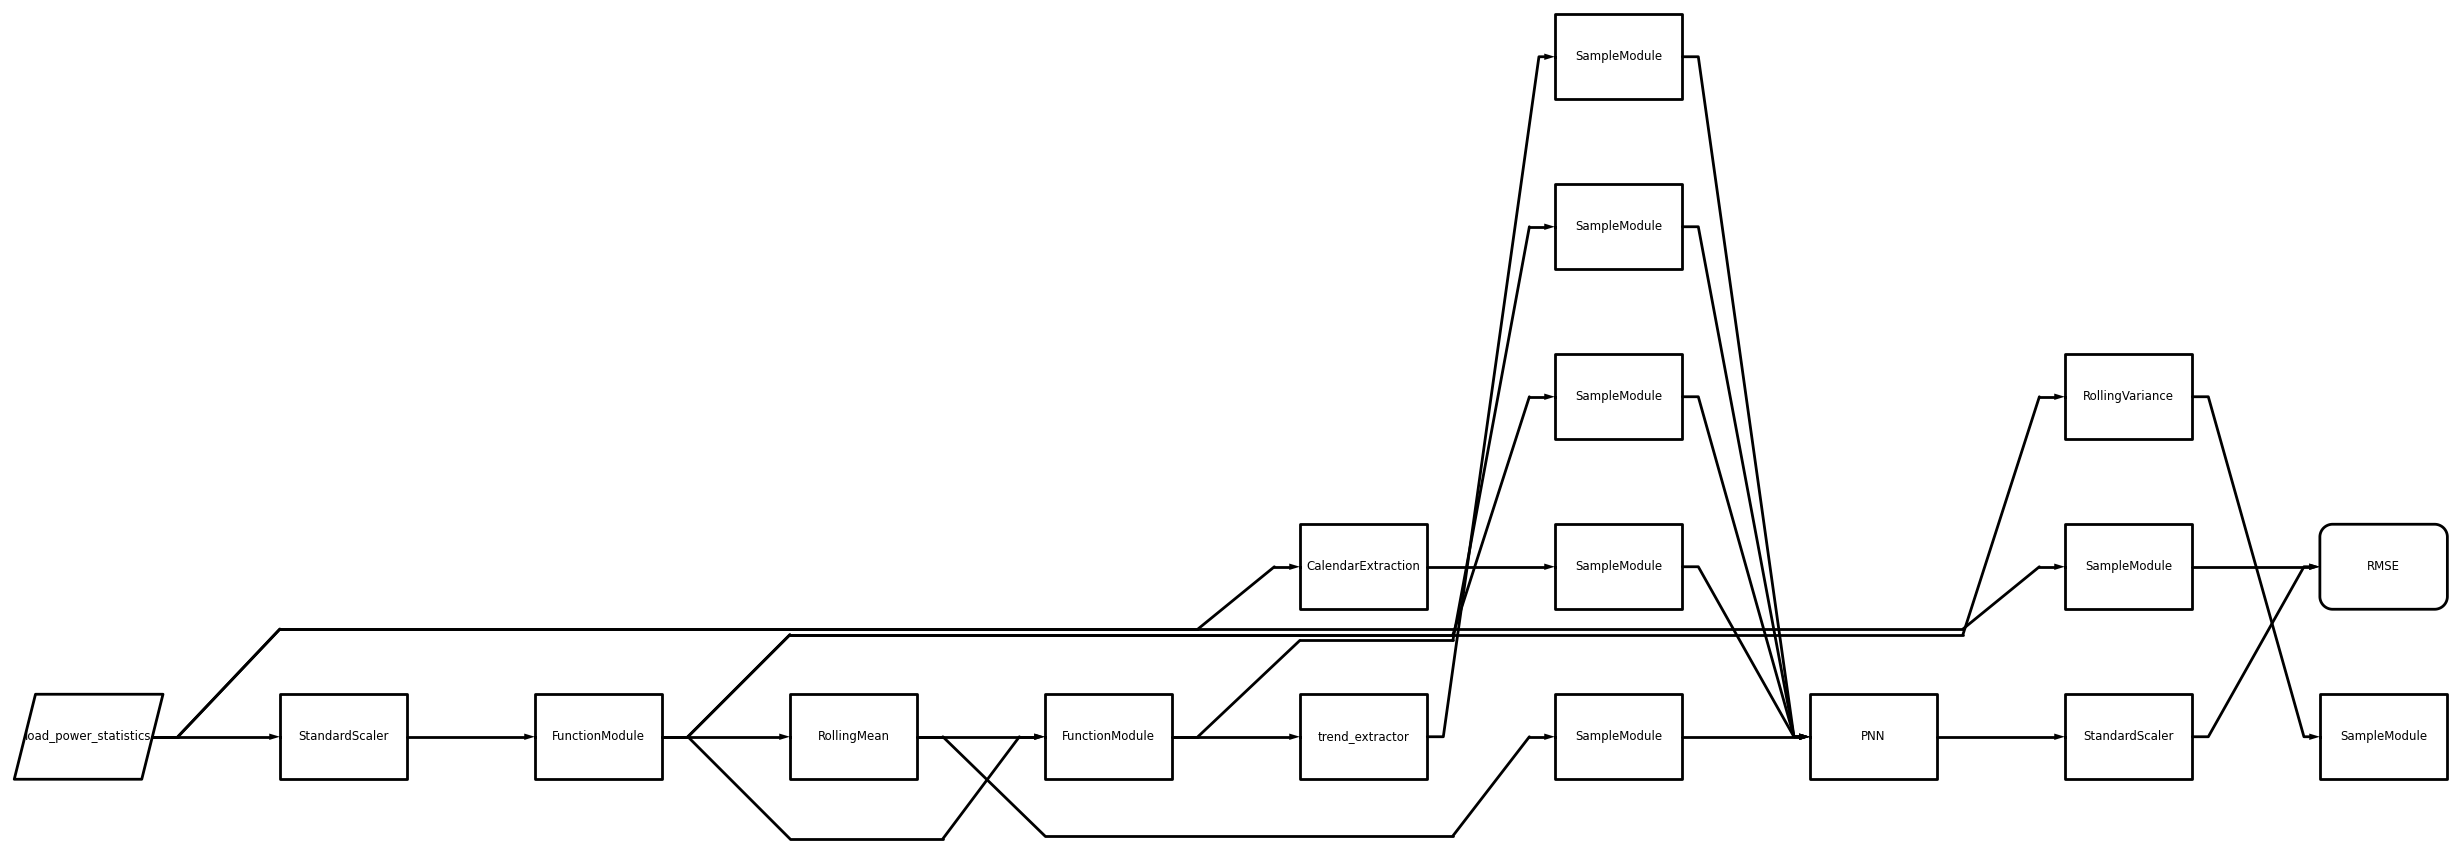

In [41]:
pipeline.draw().draw()

### Reading in the Data
TODO - Describe the data in more detail once the code is there

In [25]:
data = load_elec_data()

train_data = data[:6000]
test_Data = data[6000:]


### Training the Pipeline
TODO - Describe the training process in more detail once the code is there

In [46]:
pipeline.train(train_data)

Epoch 1/200
38/38 [==============================] - 2s 23ms/step - loss: 11.4553 - _root_mean_squared_error: 0.6552 - val_loss: 5.6333 - val__root_mean_squared_error: 0.4267
Epoch 2/200
38/38 [==============================] - 0s 12ms/step - loss: 7.0401 - _root_mean_squared_error: 0.5047 - val_loss: 5.7317 - val__root_mean_squared_error: 0.4475
Epoch 3/200
38/38 [==============================] - 0s 12ms/step - loss: 4.7176 - _root_mean_squared_error: 0.4182 - val_loss: 4.4025 - val__root_mean_squared_error: 0.4046
Epoch 4/200
38/38 [==============================] - 0s 12ms/step - loss: 3.7656 - _root_mean_squared_error: 0.3737 - val_loss: 2.5639 - val__root_mean_squared_error: 0.3078
Epoch 5/200
38/38 [==============================] - 0s 12ms/step - loss: 3.3655 - _root_mean_squared_error: 0.3530 - val_loss: 1.8447 - val__root_mean_squared_error: 0.2620
Epoch 6/200
38/38 [==============================] - 0s 12ms/step - loss: 3.1095 - _root_mean_squared_error: 0.3383 - val_loss: 1

({'SampleModule_3': <xarray.DataArray (time: 5977, horizon: 24)>
  array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
          0.        ],
         [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
          0.        ],
         [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
          0.        ],
         ...,
         [0.01437615, 0.01395759, 0.03860023, ..., 0.04536368, 0.02771919,
          0.0186887 ],
         [0.01395759, 0.03860023, 0.03283258, ..., 0.02771919, 0.0186887 ,
          0.01330625],
         [0.03860023, 0.03283258, 0.02873526, ..., 0.0186887 , 0.01330625,
          0.01198343]])
  Coordinates:
    * time     (time) datetime64[ns] 2018-01-01 2018-01-01T01:00:00 ... 2018-09-07
  Dimensions without coordinates: horizon,
  'SampleModule_6': <xarray.DataArray 'load_power_statistics' (time: 5977, horizon: 24)>
  array([[45313.9081633, 44142.3469388, 42825.4285714, ..., 50253.2244898,
          49510.6428571, 46

### Testing the pipeline
TODO - Describe the testing process and results in more detail once the code is there

In [47]:
from pywatts_pipeline.core.summary.summary_formatter import SummaryJSON

_, summary = pipeline.test(test_Data, reset=True, summary_formatter=SummaryJSON())
pd.DataFrame(summary["Summary"]["RMSE"])

85/85 [==============================] - 0s 3ms/step


,additional_information,results
mlp,,3650.691887
unscaled_pnn_,,3309.662321


We hope you found this example interesting. If you have any questions please don't hesitate to contact us at [pywatts-team@iai.kit.edu](mailto:pywatts-team@iai.kit.edu)